# Importing Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

from copy import deepcopy
from scipy.sparse import csr_matrix, vstack
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from scipy.linalg import get_blas_funcs
from sklearn.semi_supervised import LabelPropagation, LabelSpreading
# Import packages and libraries
import numpy as np
import pandas as pd
import random as rnd
import re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import KFold, StratifiedKFold, ShuffleSplit
from sklearn import metrics

from time import time
from pprint import pprint
from copy import deepcopy
from wordcloud import WordCloud 
from os import path
from PIL import Image

from nltk.corpus import stopwords
stop_words = stopwords.words('english')
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy

# Function for Semi-supervised Multinomial NB with EM

In [2]:
class Semi_EM_MultinomialNB():
    """
    Naive Bayes classifier for multinomial models for semi-supervised learning.
    
    Use both labeled and unlabeled data to train NB classifier, update parameters
    using unlabeled data, and all data to evaluate performance of classifier. Optimize
    classifier using Expectation-Maximization algorithm.
    """
    def __init__(self, alpha=1.0, fit_prior=True, class_prior=None, max_iter=30, tol=1e-6, print_log_lkh=True):
        self.alpha = alpha
        self.fit_prior = fit_prior
        self.class_prior = class_prior
        self.clf = MultinomialNB(alpha=self.alpha, fit_prior=self.fit_prior, class_prior=self.class_prior)
        self.log_lkh = -np.inf # log likelihood
        self.max_iter = max_iter # max number of EM iterations
        self.tol = tol # tolerance of log likelihood increment
        self.feature_log_prob_ = np.array([]) # Empirical log probability of features given a class, P(x_i|y).
        self.coef_ = np.array([]) # Mirrors feature_log_prob_ for interpreting MultinomialNB as a linear model.
        self.print_log_lkh = print_log_lkh # if True, print log likelihood during EM iterations

    def fit(self, X_l, y_l, X_u):
        """
        Initialize the parameter using labeled data only.
        Assume unlabeled class as missing values, apply EM on unlabeled data to refine classifier.
        """
        n_ul_docs = X_u.shape[0] # number of unlabeled samples
        n_l_docs = X_l.shape[0] # number of labeled samples
        # initialization (n_docs = n_ul_docs)
        clf = deepcopy(self.clf)# build new copy of classifier
        clf.fit(X_l, y_l) # use labeled data only to initialize classifier parameters
        prev_log_lkh = self.log_lkh # record log likelihood of previous EM iteration
        lp_w_c = clf.feature_log_prob_ # log CP of feature given class [n_classes, n_words]
        b_w_d = (X_u > 0) # words in each document [n_docs, n_words]
        lp_d_c = get_blas_funcs("gemm", [lp_w_c, b_w_d.T]) # log CP of doc given class [n_classes, n_docs]
        lp_d_c = lp_d_c(alpha=1.0, a=lp_w_c, b=b_w_d.T) 
        lp_c = np.matrix(clf.class_log_prior_).T # log prob of classes [n_classes, 1]
        lp_c = np.repeat(lp_c, n_ul_docs, axis=1) # repeat for each doc [n_classes, n_docs]
        lp_dc = lp_d_c + lp_c # joint prob of doc and class [n_classes, n_docs]
        p_c_d = clf.predict_proba(X_u) # weight of each class in each doc [n_docs, n_classes]
        expectation = get_blas_funcs("gemm", [p_c_d, lp_dc]) # expectation of log likelihood over all unlabeled docs
        expectation = expectation(alpha=1.0, a=p_c_d, b=lp_dc).trace() 
        self.clf = deepcopy(clf)
        self.log_lkh = expectation
        if self.print_log_lkh:
            print("Initial expected log likelihood = %0.3f\n" % expectation)
        # Loop until log likelihood does not improve
        iter_count = 0 # count EM iteration
        while (self.log_lkh-prev_log_lkh>=self.tol and iter_count<self.max_iter):
        # while (iter_count<self.max_iter):
            iter_count += 1
            if self.print_log_lkh:
                print("EM iteration #%d" % iter_count) # debug
            # E-step: Estimate class membership of unlabeled documents
            y_u = clf.predict(X_u)
            # M-step: Re-estimate classifier parameters
            X = vstack([X_l, X_u])
            y = np.concatenate((y_l, y_u), axis=0)
            clf.fit(X, y)
            # check convergence: update log likelihood
            p_c_d = clf.predict_proba(X_u)
            lp_w_c = clf.feature_log_prob_ # log CP of word given class [n_classes, n_words]
            b_w_d = (X_u > 0) # words in each document
            lp_d_c = get_blas_funcs("gemm", [lp_w_c, b_w_d.transpose()]) # log CP of doc given class [n_classes, n_docs]
            lp_d_c = lp_d_c(alpha=1.0, a=lp_w_c, b=b_w_d.transpose()) 
            lp_c = np.matrix(clf.class_log_prior_).T # log prob of classes [n_classes, 1]
            lp_c = np.repeat(lp_c, n_ul_docs, axis=1) # repeat for each doc [n_classes, n_docs]
            lp_dc = lp_d_c + lp_c  # joint prob of doc and class [n_classes, n_docs]
            expectation = get_blas_funcs("gemm", [p_c_d, lp_dc]) # expectation of log likelihood over all unlabeled docs
            expectation = expectation(alpha=1.0, a=p_c_d, b=lp_dc).trace() 
            if self.print_log_lkh:
                print("\tExpected log likelihood = %0.3f" % expectation)
            if (expectation-self.log_lkh >= self.tol):
                prev_log_lkh = self.log_lkh
                self.log_lkh = expectation
                self.clf = deepcopy(clf)
            else:
                break
        self.feature_log_prob_ = self.clf.feature_log_prob_
        self.coef_ = self.clf.coef_
        return self

    def predict(self, X):
        return self.clf.predict(X)

    def score(self, X, y):
        return self.clf.score(X, y)

    def get_params(deep=True):
        return self.clf.get_params(deep)

    def __str__(self):
        return self.clf.__str__()

# Preprocessing Step

In [3]:
def remove_noise(X):
        # Convert to list
        data = X

        # Remove Emails
        data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

        # Remove new line characters
        data = [re.sub('\s+', ' ', sent) for sent in data]

        # Remove single quotes
        data = [re.sub("\'", "", sent) for sent in data]

        
        def sent_to_words(sentences):
            for sentence in sentences:
                yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

        data_words = list(sent_to_words(data))
        
        def remove_stopwords(texts):
            return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
        
        # Remove Stop Words
        data_words_nostops = remove_stopwords(data_words)

        def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
            texts_out = []
            for sent in texts:
                doc = nlp(" ".join(sent)) 
                texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
            return texts_out

        # Initialize spacy model
        nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

        # Do lemmatization keeping only Noun, Adj, Verb, Adverb
        data_lemmatized = lemmatization(data_words_nostops, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
        
        return(data_lemmatized)

# Cross Validation Function

In [4]:
def cross_validation(clf, data_X, data_y, unlabeled,X_u,X_test,y_test,n_folds=5):
    print('=' * 80)
    print("Validation: ")
    print(clf)
    kf = StratifiedKFold(n_splits=n_folds)
    start_time = time()
    train_scores = list() # training accuracy
    test_scores_append= list() #test accuracy
    fold_count = 1
    original_clf = deepcopy(clf)
    avg_accuracy = 0
    test_avg_accuracy = 0
    for train_ids, valid_ids in kf.split(data_X, data_y):
        cv_clf = deepcopy(original_clf)
        print("Fold # %d" % fold_count)
        fold_count += 1
        train_X, train_y, valid_X, valid_y = data_X[train_ids], data_y[train_ids], data_X[valid_ids], data_y[valid_ids]
        if unlabeled==True:
            cv_clf.fit(train_X, train_y, X_u)
        else:
            cv_clf.fit(train_X, train_y)
        pred = cv_clf.predict(valid_X)
        test_pred=cv_clf.predict(X_test)
        scores = dict()
        scores['accuracy'] = metrics.accuracy_score(valid_y, pred)
        scores['recall'] = metrics.recall_score(valid_y, pred, average='macro')
        scores['precision'] = metrics.precision_score(valid_y, pred, average='macro')
        scores['f1_score'] = metrics.f1_score(valid_y, pred, average='macro')
        train_scores.append(scores)
        avg_accuracy += scores['accuracy']
        test_scores = dict()
        test_scores['accuracy'] = metrics.accuracy_score(y_test, test_pred)
        test_scores['recall'] = metrics.recall_score(y_test, test_pred, average='macro')
        test_scores['precision'] = metrics.precision_score(y_test, test_pred, average='macro')
        test_scores['f1_score'] = metrics.f1_score(y_test, test_pred, average='macro')
        test_scores_append.append(test_scores)
        test_avg_accuracy += test_scores['accuracy']
    train_time = time() - start_time
    print("Validation time: %0.3f seconds" % train_time)
    print("Average training accuracy: %0.3f" % (avg_accuracy/n_folds))
    print("Average testing accuracy: %0.3f" % (test_avg_accuracy/n_folds))
    return train_scores, train_time, test_scores_append

# Loading dataset and splitting into train and test

In [5]:
# Load data set with class labels and split into train and test set
test_size_ratio = 0.2
data_Xy = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'), shuffle=True)
category_names = data_Xy.target_names # text names of all categories
train_X, test_X, train_y, test_y = train_test_split(data_Xy.data, data_Xy.target, test_size=test_size_ratio, stratify=data_Xy.target)
print("Training set size: %8d\tTest set size: %8d" % (len(train_X), len(test_X)))

Training set size:    15076	Test set size:     3770


# Cleaning training set

In [6]:
# preprocess train and test text data
train_X_clean=remove_noise(train_X)
test_X_clean=remove_noise(test_X)
x=[]
train_X_clean_new=[]
for row in train_X_clean:
    x=[word for word in row if len(word)>2]
    train_X_clean_new.append(x)
print(train_X_clean_new[1])

['have', 'read', 'noam', 'chomskys', 'work', 'widely', 'use', 'information', 'net', 'outside', 'control', 'right', 'people', 'unthinkable', 'hundred', 'billion', 'dollar', 'spend', 'wipe', 'sorry', 'regulate', 'order', 'major', 'medium', 'poitical', 'power', 'wake', 'efect', 'bothered', 'reading', 'get', 'video', 'manufacturing', 'consent']


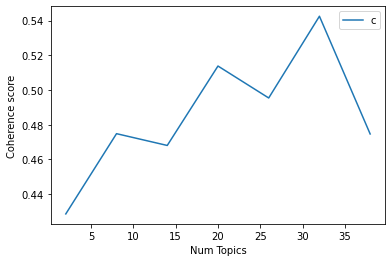

In [7]:
dictionary_LDA = corpora.Dictionary(train_X_clean_new)

# Term Document Frequency
train_corpus = [dictionary_LDA.doc2bow(data_lemmatized) for data_lemmatized in train_X_clean_new]

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
            coherence_values = []
            model_list = []
            for num_topics in range(start, limit, step):
                model = gensim.models.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
                model_list.append(model)
                coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
                coherence_values.append(coherencemodel.get_coherence())
            return model_list, coherence_values
model_list, coherence_values = compute_coherence_values(dictionary=dictionary_LDA, corpus=train_corpus, texts=train_X_clean_new, start=2, limit=40, step=6)
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Creating LDA topic model

In [8]:
# Build LDA model
num_topics = 31
lda_model = gensim.models.LdaModel(train_corpus, num_topics=num_topics, id2word=dictionary_LDA, passes=10, alpha=[0.01]*num_topics, eta=[0.01]*len(dictionary_LDA.keys()))
train_topics = [lda_model[train_corpus[i]] for i in range(len(train_X_clean))]
def topics_document_to_dataframe(topics_document, num_topics):
        res = pd.DataFrame(columns=range(num_topics))
        for topic_weight in topics_document:
            res.loc[0, topic_weight[0]] = topic_weight[1]
        return res
train_features=pd.concat([topics_document_to_dataframe(topics_document, num_topics=num_topics) for topics_document in train_topics]) \
            .reset_index(drop=True).fillna(0)

# Visualizing topics

In [9]:
# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import pyLDAvis.gensim_models
import matplotlib.pyplot as plt
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, train_corpus, dictionary_LDA)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
23     0.215809 -0.101695       1        1  17.848004
16     0.176490 -0.058246       2        1   7.314955
22     0.068790  0.000810       3        1   6.030156
12     0.128378  0.109265       4        1   5.037530
10     0.188991  0.143858       5        1   4.765421
27     0.084572 -0.156261       6        1   4.682329
21     0.011196 -0.227204       7        1   4.055637
25     0.077342 -0.124830       8        1   3.865561
28     0.171718  0.125958       9        1   3.764871
7      0.031882 -0.207720      10        1   3.615120
0     -0.071245 -0.129088      11        1   3.461259
8      0.063753  0.178631      12        1   3.407300
1      0.103955 -0.052985      13        1   3.325049
29     0.080918 -0.146710      14        1   3.242969
13     0.120525  0.064521      15        1   2.887382
2      0.042503  0.050166      16        1   2.817202
5      0.037504  0.005113      17        1   2.572002
26     0.019971 -0.045774      18        1   2.349933
6      0.066302  0.222399      19        1   1.810100
30     0.046357  0.102186      20        1   1.785308
3     -0.098993 -0.062992      21        1   1.674638
15    -0.024587  0.108065      22        1   1.421940
24    -0.017031  0.191302      23        1   1.414520
14    -0.065286 -0.117354      24        1   1.309209
9     -0.255070  0.110997      25        1   1.162428
4     -0.127606  0.004160      26        1   0.935306
20    -0.136320 -0.020452      27        1   0.880478
18    -0.172049 -0.032359      28        1   0.843024
17    -0.216237  0.027929      29        1   0.713562
19    -0.250192 -0.007379      30        1   0.554255
11    -0.302342  0.045688      31        1   0.452549, topic_info=         Term         Freq        Total Category  logprob  loglift
2196      max  3719.000000  3719.000000  Default  30.0000  30.0000
118     drive  2414.000000  2414.000000  Default  29.0000  29.0000
96        use  9566.000000  9566.000000  Default  28.0000  28.0000
1004     file  3794.000000  3794.000000  Default  27.0000  27.0000
134     image  1924.000000  1924.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
1473   cramer    62.946445    76.967395  Topic31  -4.5241   5.1969
1         air   278.393595   562.423638  Topic31  -3.0373   4.6948
4815     risc    50.998145    63.778301  Topic31  -4.7346   5.1744
2567      rat    50.406069    63.454802  Topic31  -4.7462   5.1678
10611     min    74.556073   191.311981  Topic31  -4.3548   4.4557

[2016 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
18431     29  0.997399      aaa
587       21  0.986083    aaron
3589      30  0.993273      abc
5889       8  0.954565    abide
5889      10  0.040910    abide
...      ...       ...      ...
1897      18  0.995905    yeast
2087      10  0.996763  zionism
2088      10  0.993593  zionist
3586      12  0.977547      zip
3586      25  0.021918      zip

[6312 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[24, 17, 23, 13, 11, 28, 22, 26, 29, 8, 1, 9, 2, 30, 14, 3, 6, 27, 7, 31, 4, 16, 25, 15, 10, 5, 21, 19, 18, 20, 12])

# Transforming Unseen test data

In [12]:
# Term Document Frequency
test_corpus = [dictionary_LDA.doc2bow(data_lemmatized) for data_lemmatized in test_X_clean]
test_topics = [lda_model[test_corpus[i]] for i in range(len(test_X_clean))]
def topics_document_to_dataframe(topics_document, num_topics):
        res = pd.DataFrame(columns=range(num_topics))
        for topic_weight in topics_document:
            res.loc[0, topic_weight[0]] = topic_weight[1]
        return res
test_features=pd.concat([topics_document_to_dataframe(topics_document, num_topics=num_topics) for topics_document in test_topics]) \
            .reset_index(drop=True).fillna(0)

C:\Users\Vatsal\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Splitting train set into labeled and unlabeled set

In [13]:
# Divide train data set into labeled and unlabeled data sets
X_l, X_u, y_l, y_u = train_test_split(train_features, train_y, test_size=10000, stratify=train_y)
experiments = np.logspace(2.3, 3.7, num=20, base=10, dtype='int')
X_l=X_l.to_numpy()
X_u=X_u.to_numpy()

C:\Users\Vatsal\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# Cross validation using Naive Bayes

In [14]:
# Cross validation for Naive Bayes classifier 
# using labeled data set only
nb_cv_scores = list()
nb_cv_times = list()
nb_cv_test_scores = list()
for n_l_docs in experiments:
    nb_clf = MultinomialNB(alpha=1e-2)
    cv_scores, cv_time,cv_test_scores = cross_validation(nb_clf, X_l[:n_l_docs,], y_l[:n_l_docs],False,X_u,test_features.to_numpy(),test_y)
    nb_cv_scores.append(cv_scores)
    nb_cv_test_scores.append(cv_test_scores)
    nb_cv_times.append(cv_time)
    print("Number of labeled documents: %6d" % n_l_docs)

C:\Users\Vatsal\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Validation: 
MultinomialNB(alpha=0.01)
Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold # 5
Validation time: 0.151 seconds
Average training accuracy: 0.422
Average testing accuracy: 0.353
Number of labeled documents:    199
Validation: 
MultinomialNB(alpha=0.01)
Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold # 5
Validation time: 0.140 seconds
Average training accuracy: 0.458
Average testing accuracy: 0.365
Number of labeled documents:    236
Validation: 
MultinomialNB(alpha=0.01)
Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold # 5
Validation time: 0.168 seconds
Average training accuracy: 0.482
Average testing accuracy: 0.362
Number of labeled documents:    280
Validation: 
MultinomialNB(alpha=0.01)
Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold # 5
Validation time: 0.132 seconds
Average training accuracy: 0.468
Average testing accuracy: 0.390
Number of labeled documents:    331
Validation: 
MultinomialNB(alpha=0.01)
Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold # 5
Validation time: 0.165 seconds
Average training accu

# Cross validation using Semi-supervised NB

In [15]:
# Cross validation for semisupervised EM Naive Bayes classifier 
# using both labeled and unlabeled data set
em_nb_cv_scores = list()
em_nb_cv_times = list()
em_nb_cv_test_scores = list()
for n_l_docs in experiments:
    em_nb_clf = Semi_EM_MultinomialNB(alpha=1e-2, tol=100, print_log_lkh=False) # semi supervised EM based Naive Bayes classifier
    cv_scores, cv_time,cv_test_scores= cross_validation(em_nb_clf, X_l[:n_l_docs,], y_l[:n_l_docs],True,X_u,test_features.to_numpy(),test_y)
    em_nb_cv_scores.append(cv_scores)
    em_nb_cv_times.append(cv_time)
    em_nb_cv_test_scores.append(cv_test_scores)
    print("Number of labeled documents: %6d" % n_l_docs)

C:\Users\Vatsal\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Validation: 
MultinomialNB(alpha=0.01)
Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold # 5
Validation time: 23.203 seconds
Average training accuracy: 0.065
Average testing accuracy: 0.050
Number of labeled documents:    199
Validation: 
MultinomialNB(alpha=0.01)
Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold # 5
Validation time: 22.572 seconds
Average training accuracy: 0.072
Average testing accuracy: 0.048
Number of labeled documents:    236
Validation: 
MultinomialNB(alpha=0.01)
Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold # 5
Validation time: 21.665 seconds
Average training accuracy: 0.079
Average testing accuracy: 0.048
Number of labeled documents:    280
Validation: 
MultinomialNB(alpha=0.01)
Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold # 5
Validation time: 20.913 seconds
Average training accuracy: 0.073
Average testing accuracy: 0.048
Number of labeled documents:    331
Validation: 
MultinomialNB(alpha=0.01)
Fold # 1
Fold # 2
Fold # 3
Fold # 4
Fold # 5
Validation time: 20.942 seconds
Average training

# Plotting Training Scores

C:\Users\Vatsal\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0.5, 1.0, 'Cross-Validation Average Accuracy vs Number of Labeled Documents Training Data')

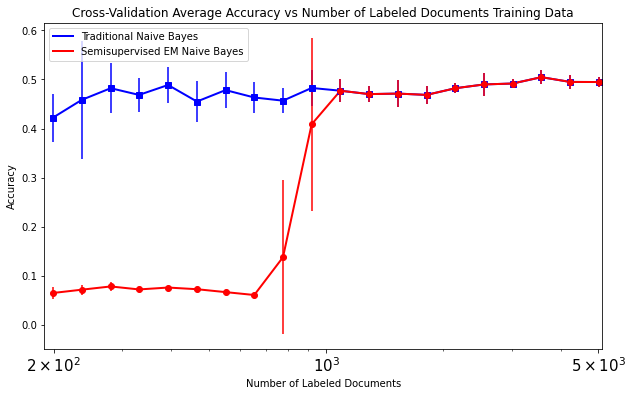

In [16]:
# plot CV accuracy comparisons
nb_score_mean = list()
nb_score_err = list()
em_nb_score_mean = list()
em_nb_score_err = list()
nb_score_test_mean = list()
nb_score_test_err = list()
em_nb_score_test_mean = list()
em_nb_score_test_err = list()
for idx in range(len(experiments)):
    nb_scores = [value['accuracy'] for value in nb_cv_scores[idx]]
    nb_score_mean.append(np.mean(nb_scores))
    nb_score_err.append(np.std(nb_scores))
    
    em_nb_scores = [value['accuracy'] for value in em_nb_cv_scores[idx]]
    em_nb_score_mean.append(np.mean(em_nb_scores))
    em_nb_score_err.append(np.std(em_nb_scores))
    
    nb_test_scores= [value['accuracy'] for value in nb_cv_test_scores[idx]]
    nb_score_test_mean.append(np.mean(nb_test_scores))
    nb_score_test_err.append(np.std(nb_test_scores))
    
    em_nb_test_scores = [value['accuracy'] for value in em_nb_cv_test_scores[idx]]
    em_nb_score_test_mean.append(np.mean(em_nb_test_scores))
    em_nb_score_test_err.append(np.std(em_nb_test_scores))
    
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)

ax.plot(experiments, nb_score_mean, color='b', linewidth=2, label='Traditional Naive Bayes')
ax.errorbar(experiments, nb_score_mean, yerr=nb_score_err, fmt='s', color='b')

ax.plot(experiments, em_nb_score_mean, color='r', linewidth=2, label='Semisupervised EM Naive Bayes')
ax.errorbar(experiments, em_nb_score_mean, yerr=em_nb_score_err, fmt='o', color='r')

ax.set_xlabel('Number of Labeled Documents')
ax.set_ylabel('Accuracy')
ax.set_xlim(left=np.min(experiments)-10, right=np.max(experiments)+100)
ax.set_xscale('log')
ax.set_xticks([200, 1000, 5000]) 
ax.set_xticklabels([r'$2\times10^2$', r'$10^3$', r'$5\times10^3$'], fontsize=15)
plt.legend(loc='upper left')
plt.title('Cross-Validation Average Accuracy vs Number of Labeled Documents Training Data')

# Plotting Test Scores

C:\Users\Vatsal\anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0.5, 1.0, 'Cross-Validation Average Accuracy vs Number of Labeled Documents Test Data')

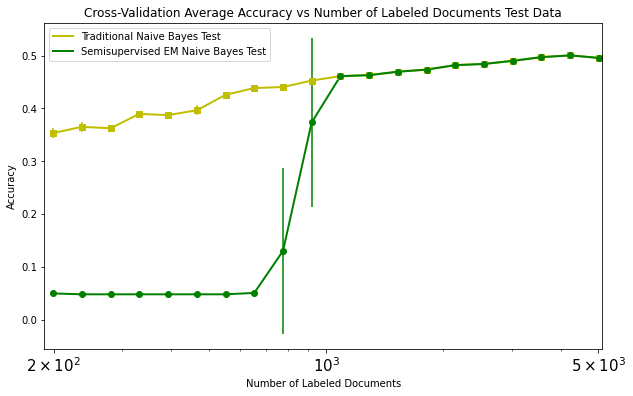

In [17]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.plot(experiments, nb_score_test_mean, color='y', linewidth=2, label='Traditional Naive Bayes Test')
ax.errorbar(experiments, nb_score_test_mean, yerr=nb_score_test_err, fmt='s', color='y')

ax.plot(experiments, em_nb_score_test_mean, color='g', linewidth=2, label='Semisupervised EM Naive Bayes Test')
ax.errorbar(experiments, em_nb_score_test_mean, yerr=em_nb_score_test_err, fmt='o', color='g')
ax.set_xlabel('Number of Labeled Documents')
ax.set_ylabel('Accuracy')
ax.set_xlim(left=np.min(experiments)-10, right=np.max(experiments)+100)
ax.set_xscale('log')
ax.set_xticks([200, 1000, 5000]) 
ax.set_xticklabels([r'$2\times10^2$', r'$10^3$', r'$5\times10^3$'], fontsize=15)
plt.legend(loc='upper left')
plt.title('Cross-Validation Average Accuracy vs Number of Labeled Documents Test Data')